In [1]:
# 
root = "/home/shi/WorkSpace/projects/scMultiNet_Data/"
feature_locs = [
    "/cls0.pkl",
    "/cls1.pkl",
    "/cls2.pkl",
    "/cls3.pkl",
    "/cls4.pkl",
]

raw_data_loc = root + "/Step_1_data/Dataset_Paul/TrVal_dataset_GTlabel.pkl"
code_loc = "/home/shi/WorkSpace/projects/scMultiNet_workspace/"

save_folder = root + "/Step_4_data/"

ckpt_folder = root+"/Step_2_data/Cook/regression/ckpt/model_d0.3_0.629.ckpt"
train_root = root + "/Step_1_data/Dataset_Paul/train/"

cls_nb = 8

In [2]:
import sys
sys.path.append(code_loc)

import dill
with open(raw_data_loc, "rb") as f:
    [trainset,valset,_,label_dict] = dill.load(f)


In [3]:
print(label_dict)

{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4, 'T5': 5, 'T6': 6, 'T7': 7}


In [4]:
# load model and calc features
import torch
import torch.nn.functional as F
import sys
DIM = 128


import torch.nn as nn
class FuseNet(nn.Module):
    def __init__(self,in_dim=128*5, dropout = 0., h_dim = 128, out_dim = 1, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        if out_key == "fc1":
            return x

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        if out_key == "fc2":
            return x
        x = self.fc3(x)
        if out_key == "all":
            return x
        else:
            raise ValueError("out_key must be one of 'fc1', 'fc2', 'all'")

class FuseNet(nn.Module):
    def __init__(self,in_dim=128*5, dropout = 0., h_dim = 128, out_dim = 1, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=1, bias=True)
        self.act2 = nn.ReLU()

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.act2(x)
        return x

# 从文件夹中读取所有类的feature matrix
import pickle
import numpy as np


read_list = ["cls0","cls1","cls2","cls3","cls4"]
#-->train
train_feat_list = []
for i in range(len(read_list)):
    with open(train_root+read_list[i]+".pkl","rb") as f:
        [feat,label] = pickle.load(f)
        train_feat_list.append(feat)
train_label = label
print(len(train_feat_list),train_feat_list[0].shape,train_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
train_feat = np.concatenate(train_feat_list,axis=1) 
train_feat = torch.from_numpy(train_feat).float()
train_label = torch.from_numpy(train_label).long() 
# label from [sample_nb,1] -> [sample_nb,class_nb]
#train_label = torch.zeros(train_label.shape[0],cls_nb).scatter_(1,train_label,1)
print(train_feat.shape,train_label.shape)

# get Dataset and DataLoader
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(train_feat,train_label)

trainloader = DataLoader(trainset,batch_size=DIM,shuffle=False)


# get model
model = FuseNet(in_dim=DIM*5, dropout = 0., h_dim = DIM, out_dim = 1, )


# load model
model.load_state_dict(torch.load(ckpt_folder))

# get features
model.eval()
feat_layer = "fc1"
all_feat = []
all_label = []
all_pred = []
all_prob = []
with torch.no_grad():
    for data in trainloader:
        inputs,label = data
        feat = model(inputs,out_key=feat_layer)
        all_feat.append(feat)
        all_label.append(label)
        pred = model(inputs,out_key="all")
        prob = pred#F.softmax(pred,dim=1)
        all_prob.append(prob)

embedding = torch.cat(all_feat,dim=0).detach().numpy()
labels = torch.cat(all_label,dim=0).detach().numpy()
prob = torch.cat(all_prob,dim=0).detach().numpy()
print(embedding.shape,labels.shape,prob.shape)

5 (1579, 128) (1579, 1)
torch.Size([1579, 640]) torch.Size([1579, 1])
(1579, 1) (1579, 1) (1579, 1)


In [5]:
# 计算 labels he preds的相关性
# 将 torch tensor 转换为 numpy 数组
# 只考虑 labels = [0,1,2,3] 的样本


A_np = labels
B_np = prob #preds 

# 计算相关性的各种度量
# 1. 皮尔逊相关系数 with p-value
from scipy.stats import pearsonr, spearmanr, kendalltau
# 计算皮尔逊相关系数和p值
correlation, p_value = pearsonr(A_np.flatten(), B_np.flatten())

print(f"pearsonr Correlation coefficient:{correlation:.3f}")
print("P-value:", p_value)

# 2. 斯皮尔曼秩相关系数
correlation_spearman, p_value_spearman = spearmanr(A_np.flatten(), B_np.flatten())
print(f"spearmanr Correlation coefficient:{correlation_spearman:.3f}")
print("P-value:", p_value_spearman)

# 3. 肯德尔秩相关系数
correlation_kendall, p_value_kendall = kendalltau(A_np.flatten(), B_np.flatten())
print(f"kendalltau Correlation coefficient: {correlation_kendall:.3f}")
print("P-value:", p_value_kendall)

pearsonr Correlation coefficient:0.630
P-value: 2.4977523514503043e-175
spearmanr Correlation coefficient:0.637
P-value: 3.964011458475643e-180
kendalltau Correlation coefficient: 0.475
P-value: 3.3941475815931677e-156


{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4, 'T5': 5, 'T6': 6, 'T7': 7}


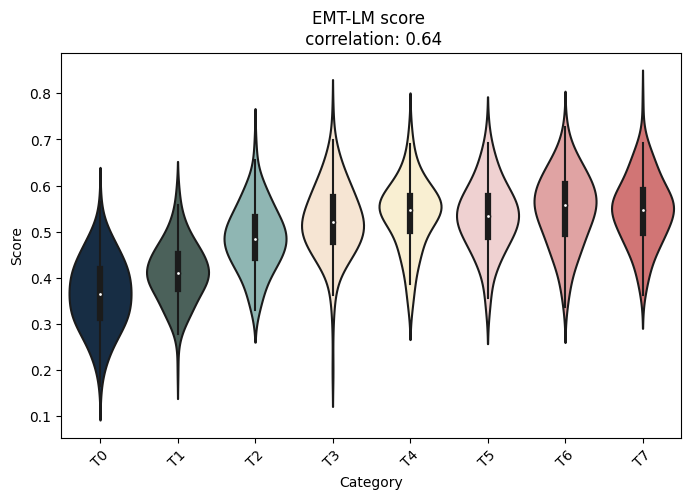

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

scores = prob

# 定义扩展后的颜色列表（十六进制格式）
hex_colors = ["#102d4b","#47655b","#89bcb8","#fce5cd","#fff2cc","#f4cccc","#ea9999","#e06666"]
# 将label和score整理到一个DataFrame中
data = pd.DataFrame({
    'Ground_truth': labels.flatten(),  # 将label数组转换为1D数组
    'Score': scores.flatten()   # 将score数组转换为1D数组
})

# 设置figure size
plt.figure(figsize=(8, 5))
# 绘制小提琴图，并使用定义的颜色
#sns.violinplot(x='Ground_truth', y='Score', data=data, palette=hex_colors)
sns.violinplot( x='Ground_truth', y='Score', data=data,palette=hex_colors,
                bw=0.5,scale='width',
                inner="box", order=sorted(data['Ground_truth'].unique()))
# 设置x轴标签
plt.xticks(range(8), label_dict.keys(), rotation=45)

# 显示图表
print(label_dict)
plt.title(f'EMT-LM score \n correlation: {correlation_spearman:.2f}')
plt.xlabel('Category')
plt.ylabel('Score')
plt.savefig(save_folder+"/paul_violin.pdf")
plt.show()

{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4, 'T5': 5, 'T6': 6, 'T7': 7}


/tmp/ipykernel_99171/1923881989.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Label', y='Score', data=data, palette=hex_colors, jitter=True)


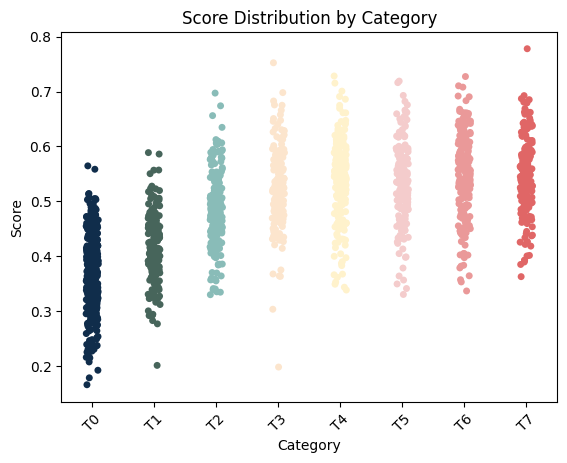

In [7]:
# data dot plot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 假设prob, new_labels和save_folder已经定义
scores = prob
data = pd.DataFrame({
    'Label': labels.flatten(),  # 将label数组转换为1D数组
    'Score': scores.flatten()   # 将score数组转换为1D数组
})

# 定义扩展后的颜色列表（十六进制格式）
hex_colors =  ["#102d4b","#47655b","#89bcb8","#fce5cd","#fff2cc","#f4cccc","#ea9999","#e06666"]
color_palette = sns.color_palette(hex_colors)  # 将十六进制颜色转换为Seaborn可用的颜色格式

# 绘制点图，并使用定义的颜色
sns.stripplot(x='Label', y='Score', data=data, palette=hex_colors, jitter=True)

# 设置x轴标签
plt.xticks(range(8), label_dict.keys(), rotation=45)

# 显示图表
print(label_dict)
plt.title('Score Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Score')
plt.savefig(save_folder + "/paul_dot_plot.pdf")
plt.show()


In [9]:
import sys
sys.path.append(code_loc)
import scLLM

# 数据集读取
import dill
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [dataset_1,dataset_2,_,_] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(dataset_1))

print(label_dict)
# reverse label_dict
rev_label_dict = {v:k for k,v in label_dict.items()}
print(rev_label_dict)
vocab = "/home/shi/WorkSpace/projects/scLLM_workspace/vocab_16k.json"
# read vocab
import json
with open(vocab,"r") as f:
    gene_names = json.load(f)
# 获取vocab按照value排序的key 的 list
#gene_names = [k for k,v in sorted(vocab.items(),key=lambda x:x[1])]
    
import scanpy as sc
# 第 1 步: 读取数据
exp_raw_data = dataset_1.data

root_label_value = label_dict["T0"]
# 第 2 步：数据准备
adata = sc.AnnData(X=exp_raw_data)
adata.var_names = [name for name, _ in sorted(gene_names.items(), key=lambda x: x[1])]
adata.obs['labels'] = labels
adata.obsm['X_emb'] = embedding  # embedding 是嵌入矩阵



# 第 3 步：Scanpy 分析

# 用嵌入矩阵计算邻居图
# 第 3 步：Scanpy 分析
import phate

phate_op = phate.PHATE()
phate_emb = phate_op.fit_transform(adata.X)
# 将 PHATE 嵌入结果存储到 AnnData 对象中
adata.obsm['X_phate'] = phate_emb

# 使用 PHATE 嵌入计算邻居图
sc.pp.neighbors(adata, use_rep='X_phate')

# 运行 DPT 分析
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.flatnonzero(adata.obs['labels'] == root_label_value)[0]
sc.tl.dpt(adata)

l_list = adata.obs['labels'].to_list()
l_list = [rev_label_dict[i] for i in l_list]
adata.obs['GT'] = l_list

# preds to str with label_dict
#pred_name = [rev_label_dict[i] for i in preds]
adata.obs["pred_labels"] = prob*10 #preds *10

trainset size:  1579
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4, 'T5': 5, 'T6': 6, 'T7': 7}
{0: 'T0', 1: 'T1', 2: 'T2', 3: 'T3', 4: 'T4', 5: 'T5', 6: 'T6', 7: 'T7'}
Calculating PHATE...
  Running PHATE on 1579 observations and 16906 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.11 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 1.24 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.33 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.24 seconds.
Calculated PHATE in 3.06 seconds.


/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shi/anaconda3/envs/scLLM/lib/python3.9/site-packages/umap/distances.py:108

In [10]:
adata.obs['GT']

0       T6
1       T5
2       T2
3       T1
4       T1
        ..
1574    T0
1575    T7
1576    T0
1577    T6
1578    T7
Name: GT, Length: 1579, dtype: object

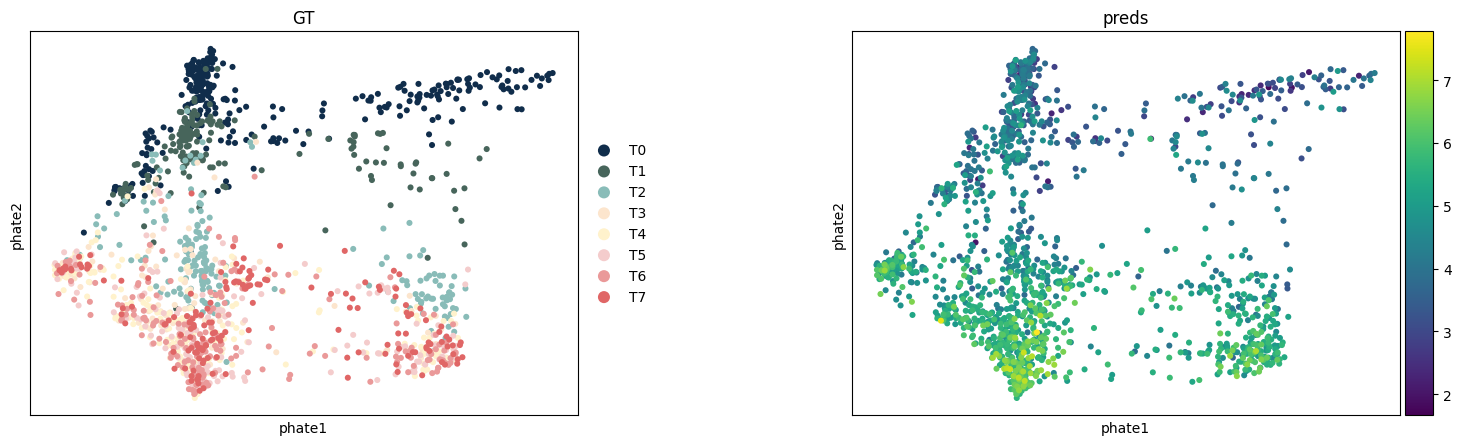

In [11]:
# 第 4 步：结果分析和可视化
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 第 4 步：结果分析和可视化
# 创建一个从红色到蓝色的颜色映射
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "blue"])

# 确保类别顺序
adata.obs['GT'] = adata.obs['GT'].astype('category')
adata.obs['GT'] = adata.obs['GT'].cat.reorder_categories([rev_label_dict[i] for i in range(8)])

# 将颜色映射到GT类别并保存到adata.uns中
adata.uns['GT_colors'] = hex_colors

sc.settings.figdir = save_folder
# 在 PHATE 嵌入上进行 DPT 可视化
sc.pl.scatter(adata, basis='phate', color=["GT","pred_labels"], title=['GT',"preds"], save="_paul_val.pdf")

In [12]:
# 计算 labels he preds的相关性
# 将 torch tensor 转换为 numpy 数组
# 只考虑 labels = [0,1,2,3] 的样本


A_np = np.array(adata.obs["dpt_pseudotime"])
B_np = np.array(adata.obs["pred_labels"]) #preds 

# 计算相关性的各种度量
# 1. 皮尔逊相关系数 with p-value
from scipy.stats import pearsonr, spearmanr, kendalltau
# 计算皮尔逊相关系数和p值
correlation, p_value = pearsonr(A_np.flatten(), B_np.flatten())

print(f"pearsonr Correlation coefficient:{correlation:.2f}")
print("P-value:", p_value)

# 2. 斯皮尔曼秩相关系数
correlation_spearman, p_value_spearman = spearmanr(A_np.flatten(), B_np.flatten())
print(f"spearmanr Correlation coefficient:{correlation_spearman:.2f}")
print("P-value:", p_value_spearman)

# 3. 肯德尔秩相关系数
correlation_kendall, p_value_kendall = kendalltau(A_np.flatten(), B_np.flatten())
print(f"kendalltau Correlation coefficient: {correlation_kendall:.2f}")
print("P-value:", p_value_kendall)

pearsonr Correlation coefficient:0.62
P-value: 3.7717270720711115e-165
spearmanr Correlation coefficient:0.68
P-value: 2.331371673283553e-218
kendalltau Correlation coefficient: 0.48
P-value: 1.3261758839554632e-177
